In [1]:
# load libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

# see process_data.py
import process_data as data

In [2]:
# load raw data 
mortality_path = os.path.join("..", "data", "mortality_profiles")
mortality_data = glob.glob(os.path.join(mortality_path, "*.csv")) 
mortality_data = mortality_data[1:len(mortality_data) - 1] # only get 1999 - 2021 data
print(mortality_data) 

['..\\data\\mortality_profiles\\1999-2008-final-deaths-by-year-by-zip-code.csv', '..\\data\\mortality_profiles\\2009-2018-final-deaths-by-year-by-zip-code.csv', '..\\data\\mortality_profiles\\2019-2021-final-deaths-by-year-by-zip-code.csv']


  ZIPCODE                                           geometry
0   90001  POLYGON ((-118.24338 33.98924, -118.24333 33.9...
1   90002  POLYGON ((-118.23431 33.96101, -118.23425 33.9...
2   90003  POLYGON ((-118.28285 33.97597, -118.28285 33.9...
3   90004  POLYGON ((-118.28410 34.08349, -118.28425 34.0...
4   90005  MULTIPOLYGON (((-118.33541 34.06179, -118.3350...


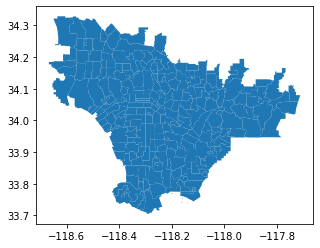

In [3]:
# load zipcode data 
zipcodes_shp = os.path.join("..", "processed", "collapsed_measures", "zipcodes_processed.shp") 
zipcodes = gpd.read_file(zipcodes_shp)
zipcodes["ZIPCODE"] = zipcodes["ZIPCODE"].astype("string").str[0:5]
print(zipcodes.head())

zipcodes.plot()
plt.show()

(257, 2)


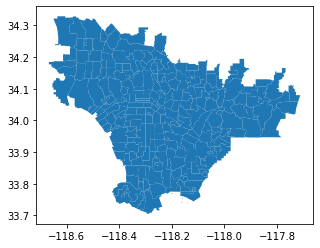

In [4]:
# see how many zipcodes are covered by mortality data 

# open up any csv 
ex_df = pd.read_csv(mortality_data[0])
unique_zips = list(map(str, ex_df.ZIP_Code.unique()))

# plot these zipcodes
zips_to_plot = zipcodes[zipcodes["ZIPCODE"].isin(unique_zips)]
print(zips_to_plot.shape) # all zipcodes are covered! yayay
zips_to_plot.plot()
plt.show()


In [5]:
# check if zipcodes are same across files (yes)
for data in mortality_data:
    df = pd.read_csv(data)
    zips = list(map(str, df.ZIP_Code.unique()))

    if (zips != unique_zips):
        raise Exception(f"{data} has dif zipcodes")

In [6]:
# wanted colnames 
age_colnames = {
    "Under 1 year" : "Age_Under_1",
    "1-4 years" : "Age_1_4", 
    "5-14 years" : "Age_5_14", 
    "15-24 years" : "Age_15_24", 
    "25-34 years" : "Age_25_34", 
    "35-44 years" : "Age_35_44", 
    "45-54 years" : "Age_45_54", 
    "55-64 years" : "Age_55_64", 
    "65-74 years" : "Age_65_74", 
    "75-84 years" : "Age_75_84", 
    "85 years and over" : "Age_85_and_Over" 
}

cause_colnames = {
    "Accidents (unintentional injuries)" : "Accidents", 
    "All causes (total)" : "Total",
    "Alzheimer's disease" : "Alzheimers",
    "Assault (homicide)" : "Homicide", 
    "Cerebrovascular diseases" : "Cerebrovascular",
    "Chronic liver disease and cirrhosis" : "Cirrhosis",
    "Chronic lower respiratory diseases" : "Respiratory",
    "Diabetes mellitus" : "Diabetes",
    "Diseases of heart" : "Heart",
    "Essential hypertension and hypertensive renal disease" : "Hypertension", 
    "Influenza and pneumonia" : "InfluenzaPneumonia",
    "Intentional self-harm (suicide)" : "Suicide",
    "Malignant neoplasms" : "Neoplasms", 
    "Nephritis, nephrotic syndrome and nephrosis" : "Nephrosis",
    "Parkinson's disease" : "Parkinsons"
}

new_colnames = age_colnames | cause_colnames | {"ZIP_Code" : "Zipcode"}
print(new_colnames)

{'Under 1 year': 'Age_Under_1', '1-4 years': 'Age_1_4', '5-14 years': 'Age_5_14', '15-24 years': 'Age_15_24', '25-34 years': 'Age_25_34', '35-44 years': 'Age_35_44', '45-54 years': 'Age_45_54', '55-64 years': 'Age_55_64', '65-74 years': 'Age_65_74', '75-84 years': 'Age_75_84', '85 years and over': 'Age_85_and_Over', 'Accidents (unintentional injuries)': 'Accidents', 'All causes (total)': 'Total', "Alzheimer's disease": 'Alzheimers', 'Assault (homicide)': 'Homicide', 'Cerebrovascular diseases': 'Cerebrovascular', 'Chronic liver disease and cirrhosis': 'Cirrhosis', 'Chronic lower respiratory diseases': 'Respiratory', 'Diabetes mellitus': 'Diabetes', 'Diseases of heart': 'Heart', 'Essential hypertension and hypertensive renal disease': 'Hypertension', 'Influenza and pneumonia': 'InfluenzaPneumonia', 'Intentional self-harm (suicide)': 'Suicide', 'Malignant neoplasms': 'Neoplasms', 'Nephritis, nephrotic syndrome and nephrosis': 'Nephrosis', "Parkinson's disease": 'Parkinsons', 'ZIP_Code': '

In [7]:
years = range(2005, 2021)
counts_df = pd.DataFrame()

for data in mortality_data:
    df = pd.read_csv(data)
    df["ZIP_Code"] = df["ZIP_Code"].astype("string")
    df_filterd = df.loc[(df["Year"].isin(years)) & (df["ZIP_Code"].isin(zipcodes["ZIPCODE"].to_list()))].reset_index()

    # extract age-specific, all-cause counts
    df_age = df_filterd.loc[df_filterd["Strata"] == "Age"]
    df_age = df_age.pivot(index=["Year", "ZIP_Code"], columns="Strata_Name", values="Count")

    # extract cause-specific, all-age counts (and all-cause, all-age)
    df_cause = df_filterd.loc[df_filterd["Strata"] == "Total Population"]
    df_cause = df_cause.pivot(index=["Year", "ZIP_Code"], columns="Cause_Desc", values="Count")

    # join dfs
    joined = df_age.join(df_cause, on=["Year", "ZIP_Code"]).reset_index()
    joined.rename(columns=new_colnames, inplace=True)

    # concat to final df
    counts_df = pd.concat([counts_df, joined], ignore_index=True)


In [8]:
# reorder age columns 
counts_grouped = pd.DataFrame(counts_df)
counts_grouped.insert(2, "Age_Under_1", counts_grouped.pop("Age_Under_1"))
counts_grouped.insert(4, "Age_5_14", counts_grouped.pop("Age_5_14"))

counts_grouped.head()


,Year,Zipcode,Age_Under_1,Age_1_4,Age_5_14,Age_15_24,Age_25_34,Age_35_44,Age_45_54,Age_55_64,...,Cirrhosis,Respiratory,Diabetes,Heart,Hypertension,InfluenzaPneumonia,Suicide,Neoplasms,Nephrosis,Parkinsons
0,2005,90001,NaN,NaN,NaN,16.0,13.0,13.0,28.0,27.0,...,13.0,NaN,NaN,74.0,NaN,NaN,NaN,40.0,NaN,0.0
1,2005,90002,NaN,NaN,0.0,19.0,21.0,18.0,24.0,43.0,...,NaN,NaN,NaN,74.0,NaN,NaN,NaN,50.0,NaN,NaN
2,2005,90003,16.0,NaN,NaN,19.0,NaN,20.0,39.0,51.0,...,NaN,12.0,17.0,90.0,NaN,NaN,NaN,59.0,NaN,NaN
3,2005,90004,NaN,NaN,NaN,NaN,NaN,15.0,34.0,22.0,...,NaN,NaN,NaN,79.0,NaN,NaN,NaN,70.0,NaN,0.0
4,2005,90005,NaN,NaN,0.0,NaN,NaN,NaN,15.0,23.0,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,39.0,NaN,NaN


In [9]:
counts_grouped["Age_0_4"] = counts_grouped.loc[:, "Age_Under_1":"Age_1_4"].sum(axis=1, min_count=1) # must have at least 1 entry, else use na
counts_grouped = counts_grouped.drop(counts_grouped.loc[:, "Age_Under_1":"Age_1_4"], axis=1)

counts_grouped["Age_15_64"] = counts_grouped.loc[:, "Age_15_24":"Age_55_64"].sum(axis=1, min_count=1) # must have at least 1 entry, else use na
counts_grouped = counts_grouped.drop(counts_grouped.loc[:, "Age_15_24":"Age_55_64"], axis=1)

counts_grouped["Age_65_84"] = counts_grouped.loc[:, "Age_65_74":"Age_75_84"].sum(axis=1, min_count=1) # must have at least 1 entry, else use na
counts_grouped = counts_grouped.drop(counts_grouped.loc[:, "Age_65_74":"Age_75_84"], axis=1)

In [10]:
# reorder age groups 
counts_grouped.insert(2, "Age_0_4", counts_grouped.pop("Age_0_4"))
counts_grouped.insert(4, "Age_15_64", counts_grouped.pop("Age_15_64"))
counts_grouped.insert(5, "Age_65_84", counts_grouped.pop("Age_65_84"))
counts_grouped.head()

,Year,Zipcode,Age_0_4,Age_5_14,Age_15_64,Age_65_84,Age_85_and_Over,Accidents,Total,Alzheimers,...,Cirrhosis,Respiratory,Diabetes,Heart,Hypertension,InfluenzaPneumonia,Suicide,Neoplasms,Nephrosis,Parkinsons
0,2005,90001,NaN,NaN,97.0,87.0,43.0,11.0,236.0,NaN,...,13.0,NaN,NaN,74.0,NaN,NaN,NaN,40.0,NaN,0.0
1,2005,90002,NaN,0.0,125.0,114.0,43.0,14.0,288.0,NaN,...,NaN,NaN,NaN,74.0,NaN,NaN,NaN,50.0,NaN,NaN
2,2005,90003,16.0,NaN,129.0,118.0,42.0,11.0,317.0,NaN,...,NaN,12.0,17.0,90.0,NaN,NaN,NaN,59.0,NaN,NaN
3,2005,90004,NaN,NaN,71.0,119.0,73.0,11.0,283.0,NaN,...,NaN,NaN,NaN,79.0,NaN,NaN,NaN,70.0,NaN,0.0
4,2005,90005,NaN,0.0,38.0,77.0,41.0,NaN,173.0,NaN,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,39.0,NaN,NaN


In [11]:
counts_grouped.columns

Index(['Year', 'Zipcode', 'Age_0_4', 'Age_5_14', 'Age_15_64', 'Age_65_84',
       'Age_85_and_Over', 'Accidents', 'Total', 'Alzheimers', 'Homicide',
       'Cerebrovascular', 'Cirrhosis', 'Respiratory', 'Diabetes', 'Heart',
       'Hypertension', 'InfluenzaPneumonia', 'Suicide', 'Neoplasms',
       'Nephrosis', 'Parkinsons'],
      dtype='object')

<AxesSubplot:>

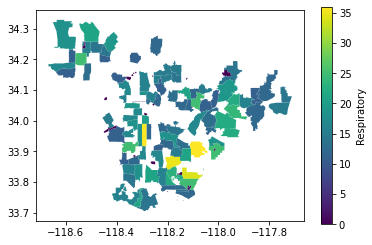

In [39]:
# visualize zipcodes that dont have data for x column for y year
col = "Respiratory"
year = 2005

filt = counts_grouped.loc[counts_grouped["Year"] == year]

# get zipcodes that have data (non na)
more_filt = filt[filt[col].notnull()]
filt_zips = list(more_filt["Zipcode"])

# get geometries and plot 
filt_zips_geos = zipcodes[zipcodes["ZIPCODE"].isin(filt_zips)]
concat_df = pd.concat([filt_zips_geos["geometry"], more_filt], axis=1)

gpd.GeoDataFrame(concat_df).plot(column="Respiratory", legend=True, legend_kwds={"label":"Respiratory"})


In [38]:
type(concat_df)

pandas.core.frame.DataFrame

In [87]:
# save counts df
out_dir = os.path.join("..", "processed", "health_data")
counts_grouped.to_csv(os.path.join(out_dir, "mortality_counts.csv"), index=False)

In [88]:
# load population data 
pop_path = os.path.join("..", "data", "pca", "ACSDP5Y2022.DP05-Data.csv ")
pop_data = pd.read_csv(pop_path)
print(pop_data.columns)

Index(['GEO_ID', 'NAME', 'DP05_0001E', 'DP05_0001M', 'DP05_0002E',
       'DP05_0002M', 'DP05_0003E', 'DP05_0003M', 'DP05_0004E', 'DP05_0004M',
       ...
       'DP05_0087PM', 'DP05_0088PE', 'DP05_0088PM', 'DP05_0089PE',
       'DP05_0089PM', 'DP05_0090PE', 'DP05_0090PM', 'DP05_0091PE',
       'DP05_0091PM', 'Unnamed: 366'],
      dtype='object', length=367)


(250, 2)
(7, 2)


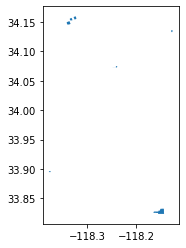

In [89]:
# get cols of interest
cols_to_keep = ["NAME",	"DP05_0001E"] # zipcode name, zipcode pop 
pop_df = pop_data[cols_to_keep]

# remove second row (descriptions of col names) 
pop_df = pop_df.drop([0])
pop_df.reset_index(drop=True, inplace=True)

# format zipcodes (remove ZCTA5_)
pop_df["NAME"] = pop_df["NAME"].str[6:]

# rename columns 
pop_df = pop_df.rename(columns={"NAME": "Zipcode", "DP05_0001E": "TotPop"}) 

# get pop for relevant zipcodes (const across all mortality files)
pop_subset_df = pop_df.loc[pop_df["Zipcode"].isin(zipcodes["ZIPCODE"].to_list())]
print(pop_subset_df.shape) 

# missing data for 7 zipcodes
pop_missing = zipcodes.loc[~zipcodes["ZIPCODE"].isin(pop_subset_df["Zipcode"].to_list())]
print(pop_missing.shape)
pop_missing.plot()
plt.show()


In [90]:
pop_subset_df.head()

,Zipcode,TotPop
0,90001,57652
1,90002,53108
2,90003,75024
3,90004,58833
4,90005,37754


In [95]:
# standardize counts to get rate per 100,000 ppl 
rate_df = pd.DataFrame()
noncount_cols = counts_grouped.columns[0:2]
count_cols = counts_grouped.columns[2:]
zips = pop_subset_df["Zipcode"].astype("string")
zip_pops = pop_subset_df["TotPop"].reset_index(drop=True).astype("float")

# get df with onyl relevant zipcodes 
# rate_df = counts_df.loc[counts_df["Zipcode"].isin(pop_subset_df["TotPop"].to_list())]

for year in years: 
    # get data for year and relevant zipcodes
    info = counts_grouped.loc[(counts_grouped["Year"] == year) & (counts_grouped["Zipcode"].isin(zips.to_list()))]
    noncounts = info.loc[:, noncount_cols].reset_index(drop=True)
    counts = info.loc[:, count_cols].reset_index(drop=True)

    # get rate 
    rate = counts.div(zip_pops, axis=0).mul(1e5)
    joined = noncounts.join(rate)

    # concat to main df
    rate_df = pd.concat([rate_df, joined], ignore_index=True)

In [97]:
rate_df.tail()

,Year,Zipcode,Age_0_4,Age_5_14,Age_15_64,Age_65_84,Age_85_and_Over,Accidents,Total,Alzheimers,...,Cirrhosis,Respiratory,Diabetes,Heart,Hypertension,InfluenzaPneumonia,Suicide,Neoplasms,Nephrosis,Parkinsons
3995,2020,91790,NaN,0.0,158.287816,430.275332,305.428603,60.193958,929.662245,46.817523,...,NaN,31.211682,46.817523,240.775833,NaN,NaN,NaN,153.829005,NaN,NaN
3996,2020,91791,0.0,0.0,144.534246,356.911097,407.055631,32.446463,952.746151,70.792284,...,NaN,32.446463,35.396142,218.276208,NaN,NaN,NaN,185.829745,NaN,NaN
3997,2020,91792,0.0,0.0,176.236862,333.247885,214.688541,NaN,740.194822,NaN,...,NaN,NaN,41.655986,169.828249,NaN,NaN,NaN,166.623943,NaN,NaN
3998,2020,91801,0.0,0.0,110.652663,300.075019,391.972993,31.882971,843.960990,41.260315,...,NaN,37.509377,35.633908,172.543136,31.882971,35.633908,NaN,170.667667,NaN,NaN
3999,2020,91803,0.0,0.0,124.112253,375.784320,358.546508,NaN,906.708957,44.818313,...,NaN,48.265876,37.923188,134.454940,NaN,55.161001,NaN,168.930566,NaN,NaN


In [102]:
# save rates df
rate_df.to_csv(os.path.join(out_dir, "mortality_rates.csv"), index=False)